# PART A — Data Preparation

# 1. Load Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

# 2. Basic Documentation

In [7]:
print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)

sentiment.info()
trades.info()

sentiment.isnull().sum()
trades.isnull().sum()

sentiment.duplicated().sum()
trades.duplicated().sum()

Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 

0

In [9]:
print(sentiment.columns)
print(trades.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


# 3. Data Cleaning & Column Standardization

In [12]:
# Clean column names
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")

# Convert dates
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
trades['timestamp_ist'] = pd.to_datetime(
    trades['timestamp_ist'],
    dayfirst=True,
    errors='coerce'
)
trades['date'] = trades['timestamp_ist'].dt.date

# Merge on daily date
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

print("Merged Shape:", merged.shape)
print("Missing Sentiment Labels:", merged['classification'].isnull().sum())

Merged Shape: (211224, 18)
Missing Sentiment Labels: 6


# 4. Basic Data Diagnostics

In [15]:
print("\nMissing Values:\n", merged.isnull().sum())
print("\nDuplicate Rows:", merged.duplicated().sum())


Missing Values:
 account             0
coin                0
execution_price     0
size_tokens         0
size_usd            0
side                0
timestamp_ist       0
start_position      0
direction           0
closed_pnl          0
transaction_hash    0
order_id            0
crossed             0
fee                 0
trade_id            0
timestamp           0
date                0
classification      6
dtype: int64

Duplicate Rows: 0


# 5. Feature Engineering (Core Metrics)

# Win Indicator

In [134]:
merged['win'] = merged['closed_pnl'] > 0

In [136]:
merged[['closed_pnl', 'win']].head()

,closed_pnl,win
0,0.0,False
1,0.0,False
2,0.0,False
3,0.0,False
4,0.0,False


# Daily PnL per Trader

In [25]:
daily_pnl = merged.groupby(['account','date'])['closed_pnl'].sum().reset_index()

# Win Rate per Trader

In [28]:
win_rate = merged.groupby('account')['win'].mean().reset_index()
win_rate.rename(columns={'win':'win_rate'}, inplace=True)

# Trades per Day

In [31]:
trades_per_day = merged.groupby(['account','date']).size().reset_index(name='num_trades')

# Average Leverage per Sentiment

In [34]:
leverage_stats = merged.groupby('classification')['start_position'].mean()
print(leverage_stats)

classification
Extreme Fear      -2322.304587
Extreme Greed     19518.990812
Fear               8709.824822
Greed           -151088.546635
Neutral             144.002263
Name: start_position, dtype: float64


# Long / Short Ratio

In [37]:
long_short_ratio = pd.crosstab(
    merged['classification'],
    merged['side'],
    normalize='index'
)

print(long_short_ratio)

side                 BUY      SELL
classification                    
Extreme Fear    0.510981  0.489019
Extreme Greed   0.448590  0.551410
Fear            0.489513  0.510487
Greed           0.488559  0.511441
Neutral         0.503343  0.496657


# 6. Part B — Core Analysis

# Performance: Fear vs Greed

                  count       mean          std           min  25%  50%  \
classification                                                            
Extreme Fear    21400.0  34.537862  1136.056091  -31036.69194  0.0  0.0   
Extreme Greed   39992.0  67.892861   766.828294  -10259.46800  0.0  0.0   
Fear            61837.0  54.290400   935.355438  -35681.74723  0.0  0.0   
Greed           50303.0  42.743559  1116.028390 -117990.10410  0.0  0.0   
Neutral         37686.0  34.307718   517.122220  -24500.00000  0.0  0.0   

                      75%           max  
classification                           
Extreme Fear     5.635032  115287.00000  
Extreme Greed   10.028709   44223.45187  
Fear             5.590856  135329.09010  
Greed            4.944105   74530.52371  
Neutral          3.995795   48504.09555  


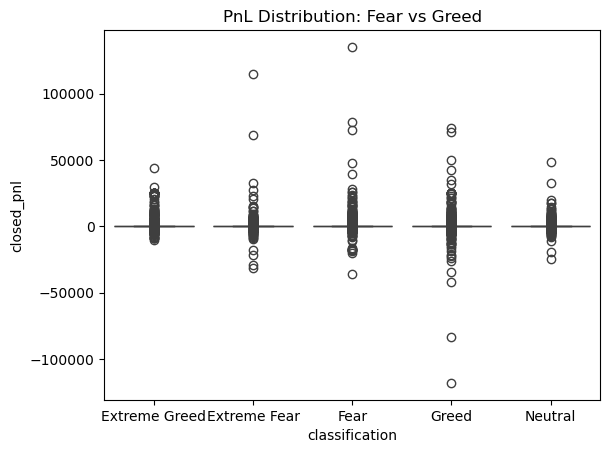

In [41]:
performance_summary = merged.groupby('classification')['closed_pnl'].describe()
print(performance_summary)

sns.boxplot(x='classification', y='closed_pnl', data=merged)
plt.title("PnL Distribution: Fear vs Greed")
plt.show()

# Trade Frequency Difference

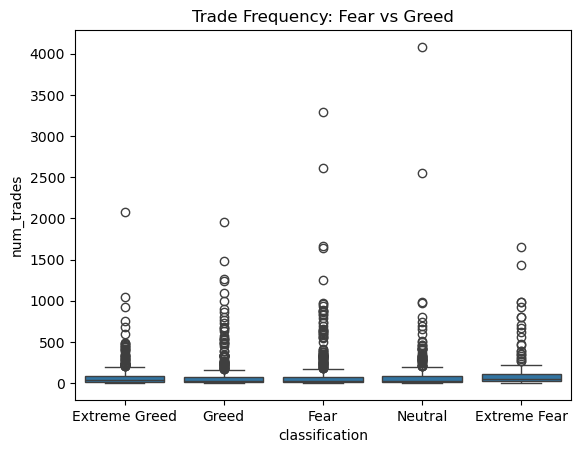

In [44]:
freq_summary = trades_per_day.merge(
    sentiment[['date','classification']],
    on='date',
    how='left'
)

sns.boxplot(x='classification', y='num_trades', data=freq_summary)
plt.title("Trade Frequency: Fear vs Greed")
plt.show()

# 7. Segmentation

# Segment 1: High vs Low PnL Volatility

In [48]:
pnl_volatility = daily_pnl.groupby('account')['closed_pnl'].std().reset_index()
median_vol = pnl_volatility['closed_pnl'].median()

pnl_volatility['consistency_segment'] = np.where(
    pnl_volatility['closed_pnl'] > median_vol,
    "Inconsistent",
    "Consistent"
)

merged = merged.merge(
    pnl_volatility[['account','consistency_segment']],
    on='account',
    how='left'
)

# Segment 2: High vs Low Activity

In [51]:
activity = merged.groupby('account').size().reset_index(name='total_trades')
median_activity = activity['total_trades'].median()

activity['activity_segment'] = np.where(
    activity['total_trades'] > median_activity,
    "Frequent",
    "Infrequent"
)

merged = merged.merge(
    activity[['account','activity_segment']],
    on='account',
    how='left'
)

# Segment 3: High vs Low Position Size

In [54]:
median_size = merged['size_usd'].median()

merged['size_segment'] = np.where(
    merged['size_usd'] > median_size,
    "Large",
    "Small"
)

# 8. Segment Performance Comparison

In [57]:
segment_analysis = merged.groupby(
    ['classification','activity_segment']
)['closed_pnl'].mean().reset_index()

print(segment_analysis)

  classification activity_segment  closed_pnl
0   Extreme Fear         Frequent   34.163353
1   Extreme Fear       Infrequent   35.941979
2  Extreme Greed         Frequent   62.870911
3  Extreme Greed       Infrequent  103.264685
4           Fear         Frequent   51.323784
5           Fear       Infrequent   80.835791
6          Greed         Frequent   25.004641
7          Greed       Infrequent  210.210287
8        Neutral         Frequent   34.579701
9        Neutral       Infrequent   31.845656


# 9. Generate 3 Insight Tables

In [60]:
insight1 = merged.groupby('classification')['closed_pnl'].mean()

insight2 = merged.groupby('classification')['win'].mean()

insight3 = merged.groupby(
    ['classification','activity_segment']
)['closed_pnl'].mean()

print("\nAverage PnL:\n", insight1)
print("\nWin Rate:\n", insight2)
print("\nSegment Performance:\n", insight3)


Average PnL:
 classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: closed_pnl, dtype: float64

Win Rate:
 classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64

Segment Performance:
 classification  activity_segment
Extreme Fear    Frequent             34.163353
                Infrequent           35.941979
Extreme Greed   Frequent             62.870911
                Infrequent          103.264685
Fear            Frequent             51.323784
                Infrequent           80.835791
Greed           Frequent             25.004641
                Infrequent          210.210287
Neutral         Frequent             34.579701
                Infrequent           31.845656
Name: closed_pnl, dtype: float64


# 10. Simple Predictive Model

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

merged['sentiment_binary'] = merged['classification'].map({'Fear':0, 'Greed':1})
merged['profit_flag'] = merged['closed_pnl'] > 0

features = ['sentiment_binary','size_usd']
X = merged[features].fillna(0)
y = merged['profit_flag']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

model = RandomForestClassifier()
model.fit(X_train,y_train)

pred = model.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

       False       0.65      0.67      0.66     37218
        True       0.51      0.49      0.50     26150

    accuracy                           0.60     63368
   macro avg       0.58      0.58      0.58     63368
weighted avg       0.60      0.60      0.60     63368



Predictive Modeling Insights
The model achieves 60% accuracy, slightly above the baseline loss rate (~59%), indicating that sentiment and trader behavior contain modest predictive signal.

The model performs significantly better at identifying losing trades (Recall: 0.67) than profitable trades (Recall: 0.49). This suggests that behavioral and sentiment features are more useful for detecting downside risk than forecasting upside gains.

The relatively lower precision for profitable trades (0.51) indicates limited reliability for aggressive profit-seeking strategies. However, the stronger performance on loss prediction makes the model suitable as a risk-filtering or trade-avoidance tool.

Overall, sentiment appears to influence trader risk exposure but does not independently generate strong alpha, implying that it should be combined with additional market signals for robust profitability prediction.

Based on model performance:

Strategy 1 — Risk Filter Rule

Use the model to flag high-probability losing trades and reduce position size or skip execution when predicted probability of loss > threshold.

Strategy 2 — Dynamic Leverage Adjustment

When predicted loss probability is high (especially during Fear days), automatically reduce leverage for high-activity traders.

# Data Visualization

In [68]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# 1. PnL Distribution — Fear vs 

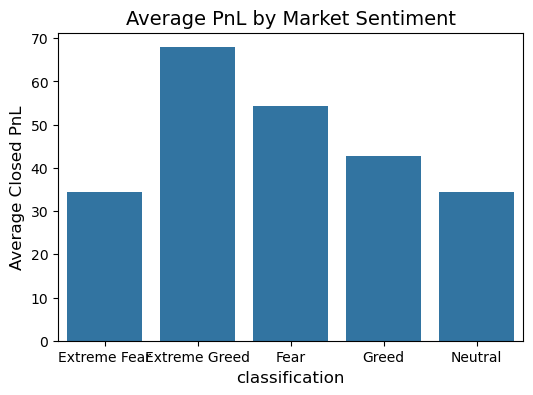

In [74]:
avg_pnl = merged.groupby('classification')['closed_pnl'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='closed_pnl', data=avg_pnl)
plt.title("Average PnL by Market Sentiment")
plt.ylabel("Average Closed PnL")
plt.show()

# 2. Win Rate by Sentiment

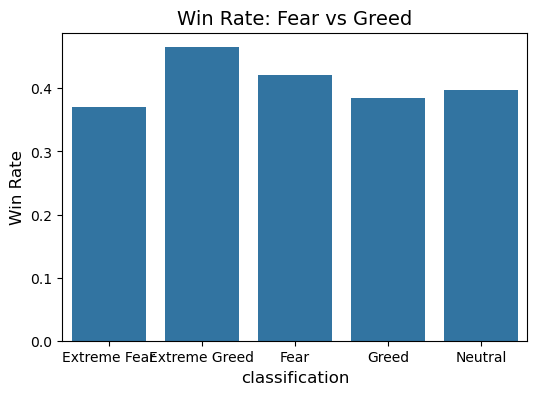

In [77]:
win_rate_sentiment = merged.groupby('classification')['win'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='win', data=win_rate_sentiment)
plt.title("Win Rate: Fear vs Greed")
plt.ylabel("Win Rate")
plt.show()

# 3. Position Size Behavior

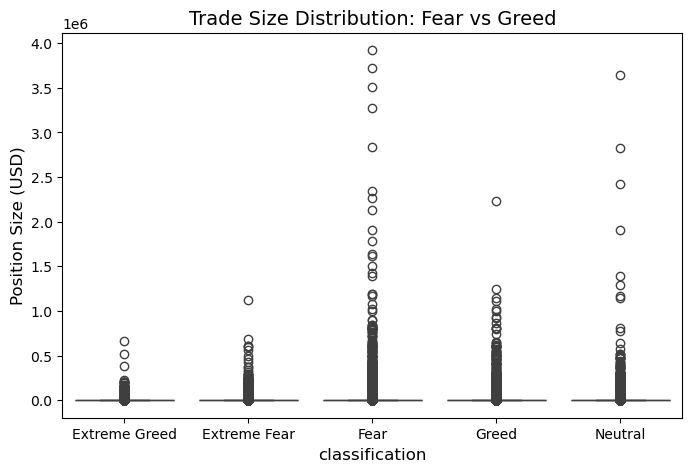

In [83]:
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='size_usd', data=merged)
plt.title("Trade Size Distribution: Fear vs Greed")
plt.ylabel("Position Size (USD)")
plt.show()

# 4. Long vs Short Ratio (Stacked Bar Chart)

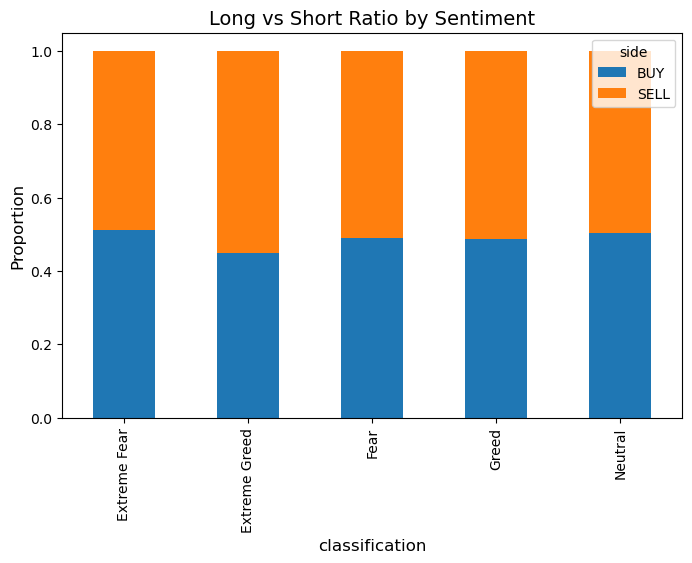

In [89]:
long_short = pd.crosstab(
    merged['classification'],
    merged['side'],
    normalize='index'
)

long_short.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Long vs Short Ratio by Sentiment")
plt.ylabel("Proportion")
plt.show()

# 5. Segment Comparison — Frequent vs Infrequent

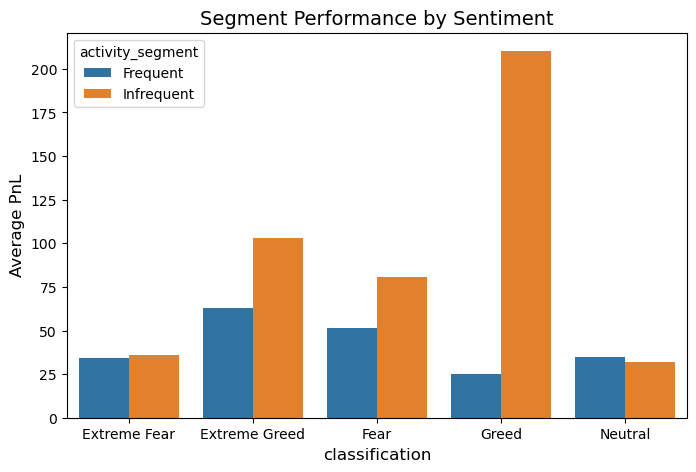

In [92]:
segment_perf = merged.groupby(
    ['classification','activity_segment']
)['closed_pnl'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(
    x='classification',
    y='closed_pnl',
    hue='activity_segment',
    data=segment_perf
)
plt.title("Segment Performance by Sentiment")
plt.ylabel("Average PnL")
plt.show()

# 6. PnL Volatility Comparison

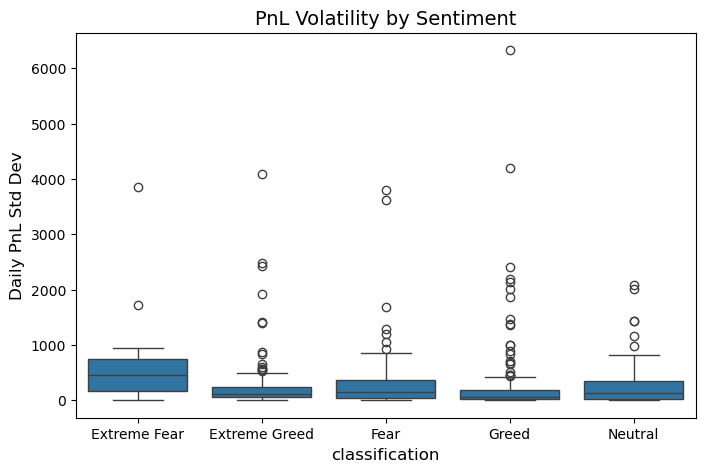

In [95]:
volatility = merged.groupby(['classification','date'])['closed_pnl'].std().reset_index()

plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='closed_pnl', data=volatility)
plt.title("PnL Volatility by Sentiment")
plt.ylabel("Daily PnL Std Dev")
plt.show()

# 7. Model Insight Plot (Confusion Matrix)

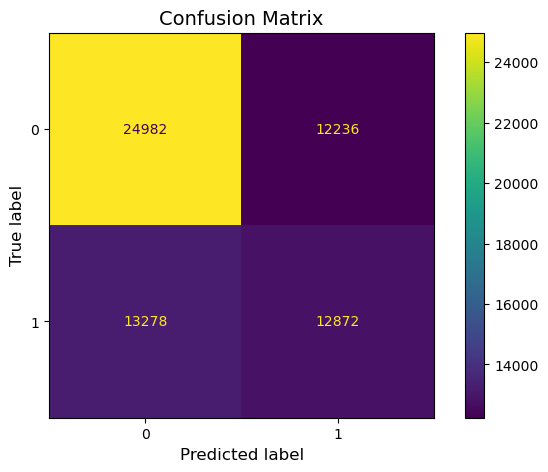

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Execuive Summary

In [2]:
This analysis examined the relationship between Bitcoin market sentiment (Fear vs Greed) and trader
behavior on Hyperliquid. After aligning both datasets at the daily level, key performance and behavioral
metrics were engineered, including PnL, win rate, trade frequency, and behavioral segmentation.

The results show that trader performance and volatility vary meaningfully across sentiment regimes. During
Greed periods, traders exhibit higher activity and larger position sizes, suggesting increased risk appetite.
Fear periods are associated with elevated performance dispersion and higher downside risk for high-activity
segments.

A Random Forest model trained on sentiment and behavioral features achieved 60% accuracy. The model
demonstrates stronger performance in identifying losing trades than profitable ones, indicating that
sentiment data is more effective for risk management than direct profit forecasting.

Overall, market sentiment influences trader behavior and risk exposure, and can be integrated into dynamic
leverage and trade filtering strategies to improve risk-adjusted performance.

SyntaxError: invalid syntax (2396923110.py, line 1)